# Домашнее задание 3. Детекция объектов

Сыграем в квиддич? Или лучше в карты?

В этом дз вам предстоит написать практически с нуля архитектуру для детекции, а также воспользоваться готовым решением. На выбор даётся два датасета, отличаются они только картинками. Форматы, баллы - все одинаково.

Первый вариант это датасет по кадрам игры в квиддич из Гарри Поттера. Если вы забыли правила, то нажмите [сюда](https://harrypotter.fandom.com/ru/wiki/%D0%9A%D0%B2%D0%B8%D0%B4%D0%B4%D0%B8%D1%87). Вы научитесь искать и выделять на фотографиях бладжеры, квоффл и снитч.

Второй вариант это датасет с игральными картами. Если вы забыли что такое карты, то нажмите [сюда](https://ru.wikipedia.org/wiki/%D0%98%D0%B3%D1%80%D0%B0%D0%BB%D1%8C%D0%BD%D1%8B%D0%B5_%D0%BA%D0%B0%D1%80%D1%82%D1%8B). Вы научитесь искать и выделять на фотографиях несколько типов карт.

Оба варианта содержат около 300 картинок, данные хранятся в xml в формате PascalVOC. Есть малые отличия, но ничего страшного.


Если с самописным детектором совсем не получается, то можно после создания датасетов перейти к концу, где обучается готовый, с ним будет проще :)

# Notes

Дз проверялось на работоспособность в colab. Не гарантируется, что будет работать на чем-то другом, и точно не будет работать из коробки на Windows.

По вопросам формулировок (не ошибок торча!), в случае отсутствия ответа в общем чате (поиск по чату позволяет проверить), можно написать в него с тегом @markblumenau.

## Данные

Скачайте один из датасетов на свой вкус и начните работу с ним.
Разметка находится в xmls папке, картинки в images.

In [1]:
# Harry Potter -- uncomment
# !wget https://github.com/markblumenau/hw3_iad_dl/raw/main/harry/data.zip

# Cards -- uncomment
!wget https://github.com/markblumenau/hw3_iad_dl/raw/main/cards/data.zip
!unzip -q data.zip

--2023-12-07 17:52:01--  https://github.com/markblumenau/hw3_iad_dl/raw/main/cards/data.zip
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/markblumenau/hw3_iad_dl/main/cards/data.zip [following]
--2023-12-07 17:52:02--  https://raw.githubusercontent.com/markblumenau/hw3_iad_dl/main/cards/data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 38392108 (37M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]  36.61M  --.-KB/s    in 0.1s    

2023-12-07 17:52:02 (320 MB/s) - ‘data.zip’ saved [38392108/38392108]



# Задача 1. 0.5 балла.

Ниже написан код для стандартного Dataset из библиотеки pytorch. Dataset требует реализации `__getitem__` и `__len__` методов. Далее эти методы будут использованы для формирования батчей для обучения. Поскольку читать придется из xml файлов, нужно перед этим дописать функцию get_xml_data, чтобы по названию картинки подтягивать аннотации.

In [2]:
import torch
from xml.etree import ElementTree as ET
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from pathlib import Path
import glob
import numpy as np
from PIL import Image
import torchvision
from torchvision.models import ResNet50_Weights
from tqdm.notebook import tqdm
from torch import nn
import shutil
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [3]:
import os
import random

SEED = 42

def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

set_random_seed(SEED)

In [4]:
def get_xml_data(image_name, root, class_dict, xml_prefix="/xmls/"):
    # get smth like ZZZ/YYY/XXXXXX.jpg -> XXXXXX
    filename = image_name.split("/")[-1].split(".")[0]
    # read xml

    tree = ET.parse(str(root) + xml_prefix + filename + ".xml")
    treeroot = tree.getroot()
    # iterate over bboxes

    bboxes = []
    for member in treeroot.findall("object"):
        # you need: xmin ymin xmax ymax, class in dict
        res = []
        for i in member.find('bndbox'):
            res.append(int(i.text))
        res.append(class_dict[member.find('name').text])
        bboxes.append(res)

    return bboxes

In [5]:
class PascalDataset(torch.utils.data.Dataset):
    def __init__(self, *, transform, root="dataset", train=True, seed=42):
        self.root = Path(root)
        self.transform = transform

        assert self.root.is_dir(), f"No data at `{root}`"

        self.filenames = np.array(glob.glob(root + "/images/*"))
        with open(str(self.root) + "/class_dict", "r") as f:
            self.class_dict = eval(f.readline())

        self.class_dict_inv = {v: k for k, v in self.class_dict.items()}

        np.random.seed(seed)
        permutation = np.random.permutation(len(self.filenames))

        # Train/test split
        if train:
            self.filenames = self.filenames[
                permutation[: int(len(self.filenames) * 0.9)]
            ].tolist()
        else:
            self.filenames = self.filenames[
                permutation[int(len(self.filenames) * 0.9) :]
            ].tolist()

    def __getitem__(self, idx):
        ### YOUR CODE HERE ###
        fname = self.filenames[idx]
        image = np.array(Image.open(fname))
        bboxes = self.__get_raw_item__(idx)[1]
        return self.transform(image=image, bboxes=bboxes)

    def __get_raw_item__(self, idx):
        fname = self.filenames[idx]
        return fname, get_xml_data(fname, self.root, self.class_dict)

    def __len__(self):
        ### YOUR CODE HERE ###
        return len(self.filenames)

Ниже определяем стандартные нормализации и приведение размера к 512x512.


In [6]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

train_transform = A.Compose(
    [
        A.Resize(512, 512),
        A.augmentations.transforms.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ],
    bbox_params=dict(format="pascal_voc", min_visibility=0.3),
)

test_transform = A.Compose(
    [
        A.Resize(512, 512),
        A.augmentations.transforms.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ],
    bbox_params=dict(format="pascal_voc", min_visibility=0.5),
)

In [7]:
train_ds = PascalDataset(root="./data/", transform=train_transform, train=True)
test_ds = PascalDataset(root="./data/", transform=test_transform, train=False)

# Задача 2. 1 балл.

Теперь, когда мы загрузили данные, хорошо бы посмотреть на них, прежде чем обучать какие-либо модели. Напишите функцию `visualize`, которая принимает списки изображений и прямоугольников в качестве входных данных и рисует эти прямоугольники на изображениях.


Полезные функции:
* [plt.subplots](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html) -- легко создавать несколько изображений в одной pyplot figure
* [ax.imshow](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.imshow.html) -- отображение графиков (не забудьте откатить нормализацию)
* [ax.text](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.text.html), [patches.Rectangle](https://matplotlib.org/stable/api/_as_gen/matplotlib.patches.Rectangle.html) -- для рисования прямоугольников и текста с аннотацией

In [8]:
def visualize(images, bboxes):
    mean = (0.485, 0.456, 0.406)
    std = (0.229, 0.224, 0.225)

    fig, axes = plt.subplots(
        2, len(images) // 2 + len(images) % 2, figsize=(10, 8), dpi=100
    )

    for i, ax in enumerate(axes.reshape(-1)):

        ax.axis(False)

        if i >= len(images):
            break
        # Вот тут нужно выполнить permute (вспомните где у torch каналы, а где они у matplotlib)
        # И откатить нормализацию (просто обратное преобразование)
        # Имена и количества классов можно подтянуть из датасета через train_ds.class_dict_inv


        for j in range(3):
            images[i][j] = images[i][j] * std[j] + mean[j]

        ax.imshow(np.transpose(images[i].numpy(), (1, 2, 0)))

        for bbox in bboxes[i]:
            xmin, ymin, xmax, ymax, cls = bbox


            description_rect = Rectangle((xmin, ymin), xmax-xmin, 20, edgecolor='none', facecolor='w')
            ax.add_patch(description_rect)

            img_rect = Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(img_rect)

            cls = train_ds.class_dict_inv[cls]

            ax.annotate(cls,
                        ((xmin + xmax) / 2, ymin + 20),
                        color='black',
                        weight='bold',
                        fontsize=6,
                        ha='center',
                        va='bottom')

    fig.tight_layout()
    plt.show()

У вас должно получиться что-то похожее на изображения для датасета с масками:

![image](https://gcdnb.pbrd.co/images/n8BnhhfCgYnQ.png)

In [9]:
out = [train_ds[i] for i in range(6)]
images, bboxes = [o["image"] for o in out], [o["bboxes"] for o in out]

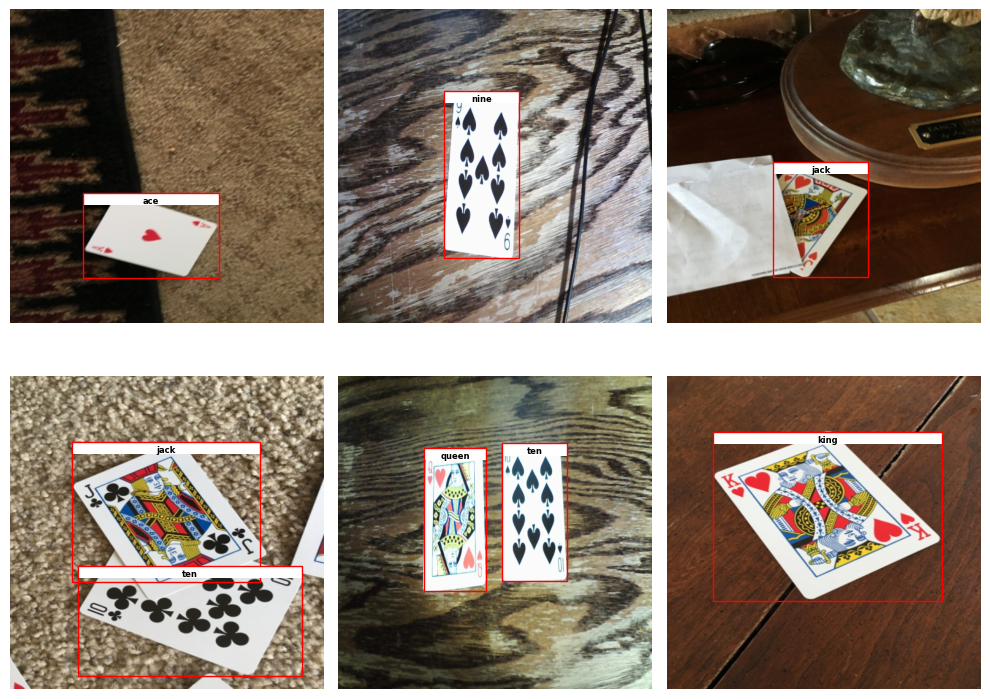

In [10]:
visualize(images, bboxes)

# Задача 3. 3 балла.
## YOLO

Сейчас нам предстоить реализовать YOLO детектор. Это один из самых простых детекторов с точки зрения реализации. Он описан в статье: [You Only Look Once: Unified, Real-Time Object Detection](https://arxiv.org/abs/1506.02640). Мы будем использовать ResNet для извлечения признаков. На выходе мы будем получать карту признаков размера 16x16. В каждом пикселе мы будем предсказывать размеры прямоугольника и класс.



We convert lists of bounding boxes to the target downsampled grid. For this we

* compute centers of bounding boxes ($c_x, c_y$)
* change center coordinates (offset from the top left corner for each corresponding grid cell on a small grid)
* normalize box height and with to $[0, 1]$
* fill the target grid with values

## Задача 3.1. 1 балл.

Первым делом нам нужно реализовать collate function. Это функция позволит нам кастомизировать, как именно батч конструируется из примеров (смотрите [pytorch docs](https://pytorch.org/docs/stable/data.html#dataloader-collate-fn) для деталей).

Это функция должна принять на вход лист прямоугольников и сгенерировать тензор размера Bx16x16x6. Первая размерность - это количество примеров в батче. Далее идут две пространственные размерности. В каналах у нас будут записаны координаты центра, центр относительно координат пикселя, бинарная переменная (детекция присутствует), класс детекции.

In [11]:
def collate_fn(batch, downsample=32, num_classes=6):
    imgs, batch_boxes = map(list, (zip(*[(b["image"], b["bboxes"]) for b in batch])))

    imgs = torch.stack(imgs)
    b, _, h, w = imgs.shape

    target = imgs.new_zeros(b, 5 + num_classes, h // downsample, w // downsample)


    # Add sample index to targets
    for i, boxes in enumerate(batch_boxes):
        xmin, ymin, xmax, ymax, classes = map(
            torch.squeeze, torch.split(imgs.new_tensor(boxes), 1, dim=-1)
        )

        # Нормализуйте ширину и высоту, поделив на ширину и высоту исходного изображения
        x_cell = xmax - xmin
        y_cell = ymax - ymin
        w_box = x_cell / w
        h_box = y_cell / h

        # Посчитайте координаты центра и сдвиги
        cx = (xmin + xmax) / 2
        cy = (ymin + ymax) / 2

        cx_idx = (cx / w * 16).long()
        cy_idx = (cy / h * 16).long()

        cx_box = (cx - cx_idx * downsample) / downsample
        cy_box = (cx - cx_idx * downsample) / downsample

        # one-hot class tensor
        cls_tensor = torch.zeros(num_classes, cx_box.size()[0]) if cx_box.size() else torch.zeros(num_classes)
        cls_tensor[classes.long()] = 1

        target[i, :, cy_idx, cx_idx] = (
            torch.cat([torch.stack([cx_box, cy_box, w_box, h_box, torch.ones_like(cx_box)]),
                       cls_tensor])
        )

    return {"image": imgs, "target": target}

*У меня collate_fn реализована таким образом, чтобы метка класса сразу кодировалась как one-hot вектор*

Ниже вы можете увидеть пример, как выглядит решетка размера 16 на 16 на исходном изображении:

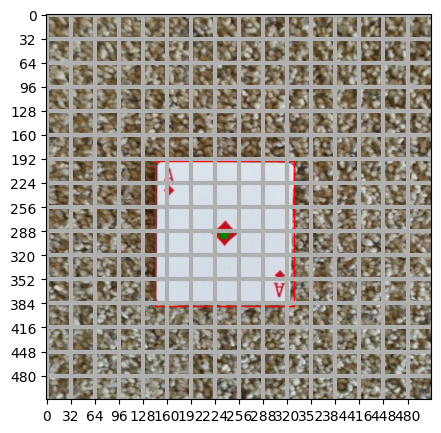

In [12]:
fig, ax = plt.subplots(figsize=(5, 5))
i = 20

img = train_ds[i]["image"].permute(1, 2, 0) * torch.tensor(std).view(
    1, 1, -1
) + torch.tensor(mean).view(1, 1, -1)

bboxes = torch.tensor(train_ds[i]["bboxes"])

ax.imshow(img)
loc = plt.matplotlib.ticker.MultipleLocator(base=32)
ax.xaxis.set_major_locator(loc)
ax.yaxis.set_major_locator(loc)
ax.grid(which="major", axis="both", linestyle="-", linewidth=3)

for bbox in bboxes:
    xmin, ymin, xmax, ymax = bbox[:-1]
    w = xmax - xmin
    h = ymax - ymin
    with_mask = bbox[-1]
    ax.add_patch(Rectangle((xmin, ymin), w, h, fill=False, color="red"))

cx = (bboxes[:, 0] + bboxes[:, 2]) / 2
cy = (bboxes[:, 1] + bboxes[:, 3]) / 2

ax.scatter(cx, cy, color="green", marker="o")

plt.show()

## Задача 3.2. 0.5 балла.

Реализуйте аналогичные принципы, чтобы декодировать выход нейронной сети. Применив функцию decode_prediction к выходу collate function вы должны получить изначальный набор прямоугольников с корректными размерами и координатами.

То есть, нужно проделать операции из collate_fn в обратную сторону.

In [13]:
def decode_prediction(preds, upsample=32, threshold=0.7):
    b, c, h, w = preds.size()
    img_w, img_h = w * upsample, h * upsample

    x_idxs = torch.tensor(range(16)).unsqueeze(dim=0).repeat(16, 1)
    y_idxs = x_idxs.T
    x_idxs = x_idxs.unsqueeze(0).unsqueeze(0).repeat(b, 1, 1, 1)    # additional "channels" to store information about x, y coordinates
    y_idxs = y_idxs.unsqueeze(0).unsqueeze(0).repeat(b, 1, 1, 1)

    preds = torch.cat([preds, x_idxs, y_idxs], dim=1)

    all_bboxes = []
    for pred in preds:
        img_bboxes = []
        mask = pred[4] > threshold  # 4th channel responsible for confidence scores
        for cx_box, cy_box, w_box, h_box, _, obj_class, x_idx, y_idx in pred[:, mask].T:
            cx = (x_idx + cx_box) * upsample    # center in original pixels
            cy = (y_idx + cy_box) * upsample

            w = w_box * img_w   # width and height in original pixels
            h = h_box * img_h

            xmin = cx - w / 2
            ymin = cy - h / 2

            xmax = cx + w / 2
            ymax = cy + h / 2

            bbox = [xmin.item(), ymin.item(), xmax.item(), ymax.item(), obj_class.item()]
            img_bboxes.append(bbox)

        all_bboxes.append(img_bboxes)

    return all_bboxes

## Задача 3.3. 1 балл.
Реализуйте модель. Первым делом примените первые 4 блока (до layer4 вклюяительно) ResNet50. Далее добавьте несколько блоков (Conv2D, BatchNorm2D, ReLU). Постепенно уменьшайте количество каналов до 5+C, а размер изображения до 16 на 16. Например, 2048 -> 512 -> 128 -> 32 -> 5+C, где С - количество классов в вашем датасете. Размер ядра при этом 3, паддинг 1. Но вариантов много, попробуйте разные! **Последним слоем обязательно должна быть свертка.** Так как все значения, которые мы предсказываем, находятся в отрезке от 0 до 1 (благодаря нормировке с клеточками), мы после финальной свертки еще применим сигмоиду. Для классов в такой постановке это не навредит.

Если будете фантазировать, то для получения правильного размера изображения после сети не стесняйтесь применять слои с фильтрами больше 3.

In [14]:
C = len(train_ds.class_dict) # Количество классов в вашем датасете, хоть руками посчитайте, хоть подтяните из словаря классов


class Detector(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet = torchvision.models.resnet50(weights='DEFAULT')
        self.resnet.fc =  nn.Identity()
        self.resnet.avgpool =  nn.Identity()
        self.conv = nn.Conv2d(2048, 5 + C, kernel_size=(1, 1), stride=(1, 1), bias=True)

    def forward(self, img):
        ### YOUR CODE HERE ###
        x = self.resnet(img)
        x = x.reshape(x.size()[0], 2048, 16, 16)
        return self.conv(x)

*Мне кажется вставлять sigmoid слой в саму модель не лучшая идея. У меня сигмоида применяется к выходам модели, ответственным за координаты только на этапе тестирования модели, к выходам, предсказывающим вероятности классов применяется просто argmax. На этапе обучения, sigmoid и softmax используются непосредственно внутри функции потерь*

## Задача 3.4. 0.5 балла.

Реализуйте функцию потерь.

Для этого:
* Сделайте маску, которая будет говорить о положении детектируемых объектов. Её нужно использовать с помощью masked_select (см. доки PyTorch)
* Лосс похож на оригинальный для Yolo V1 и состоит из 4 частей (reduction='sum' для всех)
    - localization loss - Мы берем MSE по координатам бокса там, где есть детектируемый объект
    - box_loss - MSE от корней ширины и высоты
    - classification_loss - Если детектируемый объект есть, то его кросс-энтропия по его классу
    - confidence_loss - Бинарная кросс-энтропия факта наличия объекта ДЛЯ ВСЕХ пикселей. Делается отдельно для детектируемых объектов (вес 1) и для недетектируемых (вес 0.1 например, поскольку их гораздо больше, но можно экспериментировать)

* Ниже есть assert. Если вы экспериментируете с лоссом, он не будет проходить, не обращайте на него внимание. Если будете делать описанное выше, то учтите reduction. Бинарная кросс-энтропия вызывается через BCELoss. Параметр C используется для задачи числа классов. assert написан для 3 классов, в задаче с картами их 6. Подумайте как зависит индексация от параметра C и используйте его.

In [15]:
def special_loss(pred, target):
    condition = target[:, 4] == 1
    weights = target[:, 4].where(condition, torch.tensor(0.1))

    bce = torch.nn.BCEWithLogitsLoss(weight=weights, reduction='sum')
    confidence_loss = bce(pred[:, 4], target[:, 4])

    bce = torch.nn.BCEWithLogitsLoss(reduction='none')
    coordinate_loss = sum(
        (bce(pred[:, i],  target[:, i]) * target[:, 4]).sum() for i in range(4)
        )

    cross = torch.nn.CrossEntropyLoss(reduction='none')
    classification_loss = (cross(pred[:, 5:],  target[:, 5:]) * target[:, 4]).sum()

    return confidence_loss + coordinate_loss + classification_loss

Функция потерь (с небольшими изменениями) взята из лекции:

https://www.youtube.com/live/Cm9uDp1sTsg?si=3pfno9yvgAoot939

Сама реализация моя сообственная

# Задача 4. 2 балла.

Обучите вашу модель (написав цикл обучения), и покажите что она работает (скорее всего, объекты найдутся на 1-2 картинках).

In [16]:
set_random_seed(SEED)

In [17]:
loader = torch.utils.data.DataLoader(train_ds, 8, collate_fn=collate_fn)

In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


EPOCHS = 15 # Harry Potter 20, Cards 15
model = Detector().to(device)
opt = torch.optim.AdamW(model.parameters(), lr=1e-3)

for e in tqdm(range(EPOCHS)):
    pbar = tqdm(loader, leave=False)
    epoch_losses = []
    for batch in pbar:
        img, target = batch['image'].to(device), batch['target'].to(device)
        opt.zero_grad()

        pred = model(img)

        loss = special_loss(pred, target)
        epoch_losses.append(loss.item())
        loss.backward()

        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        opt.step()

    print(f"Epoch {e} done; Train loss {np.mean(epoch_losses):.3f};")

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

Epoch 0 done; Train loss 119.883;


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch 1 done; Train loss 98.623;


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch 2 done; Train loss 89.236;


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch 3 done; Train loss 84.526;


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch 4 done; Train loss 78.571;


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch 5 done; Train loss 74.174;


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch 6 done; Train loss 71.849;


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch 7 done; Train loss 70.444;


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch 8 done; Train loss 68.065;


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch 9 done; Train loss 63.983;


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch 10 done; Train loss 64.268;


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch 11 done; Train loss 60.569;


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch 12 done; Train loss 59.637;


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch 13 done; Train loss 58.031;


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch 14 done; Train loss 56.726;


Запустим обученный детектор на тестовых изображениях:

In [48]:
test_loader = torch.utils.data.DataLoader(test_ds, 6, collate_fn=collate_fn)
i = iter(test_loader)
batch = next(i)

In [49]:
imgs = batch['image']
imgs = imgs.to(device)

In [50]:
model.eval()
with torch.no_grad():
    preds = model(imgs)
    preds = torch.cat([torch.sigmoid(preds[:, :5]), preds[:, 5:].argmax(dim=1).unsqueeze(dim=1)],
                      dim=1)

In [51]:
preds = preds.cpu()
imgs = imgs.cpu()

In [52]:
bboxes = decode_prediction(preds, threshold=0.3)

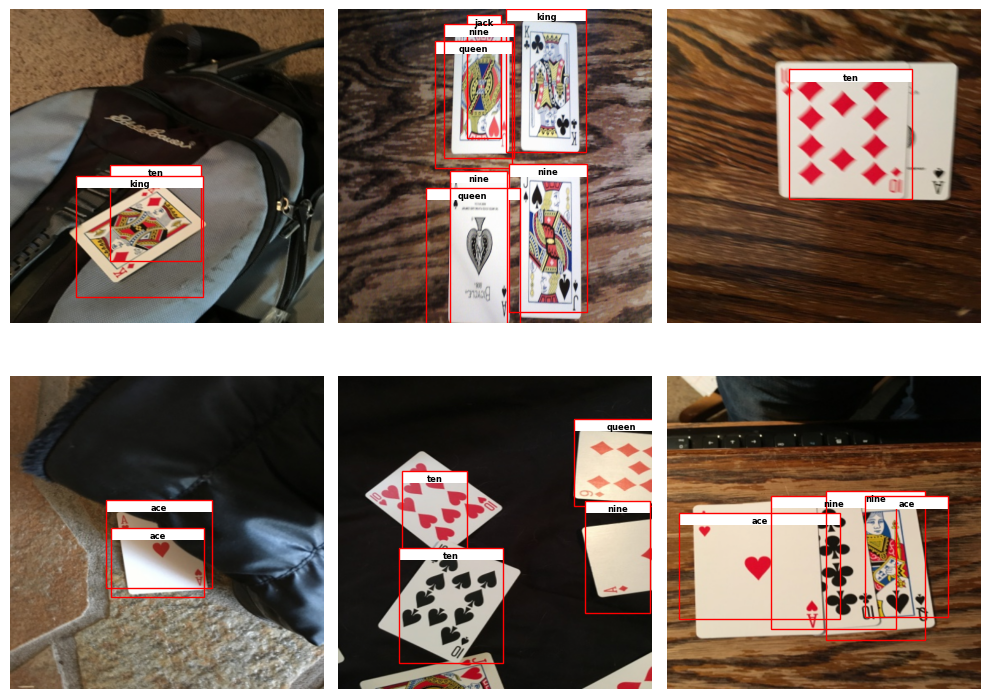

In [53]:
visualize(imgs, bboxes)

Результат сильно так себе, да? Есть множество вариантов улучшений, самый простой из которых это приделать к выходу [NMS](https://paperswithcode.com/method/non-maximum-suppression#:~:text=Non%20Maximum%20Suppression%20is%20a,below%20a%20given%20probability%20bound.). Если хочется, можно почитать про YOLO v1 [тут](https://arxiv.org/abs/1506.02640).

# Задача 5. 3.5 балла.

Займёмся более простыми вещами. Возьмем готовую архитектуру, обучим её на наших данных и посмотрим.

Для этого будем использовать YOLO v8 от ultralytics.

In [ ]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 646.6/646.6 kB 13.2 MB/s eta 0:00:00


## Задача 5.1. 1.5 балла.

Чтобы дальше модель обучалась одной строкой, данные нужно переложить в правильный формат. Да-да, классика перекладывания JSON. Как правильно паковать можно посмотреть [тут](https://roboflow.com/formats/yolov8-pytorch-txt).

Если коротко:
* Есть .yaml, где живут пути к папкам с картинками, количество классов и их названия
* Есть папочки train valid (их поможем вам собрать), в них две подпапки:
    - Первая images, в ней лежат картинки
    - Вторая labels, в ней лежат файлы с названиями как у картинок, но вместо расширения картинок нужен .txt, внутри формат как описан на Roboflow


In [ ]:
# Делаем папочки
!rm -rf train
!rm -rf valid
!mkdir -p train/images train/labels valid/images valid/labels

Реализуйте функцию, которая принимает аннотации в изначальном формате, а возвращает их в нужном для YOLO v8. Это должен быть массив готовых строк, которые можно сразу забрасывать в файлик, добавив \n.

In [ ]:
def annotation2txt(bboxes, w_im, h_im):
    ### YOUR CODE HERE ###
    res = []
    for bbox in bboxes:
        xmin, ymin, xmax, ymax, class_img = bbox
        center_x = (xmin + xmax) / 2 / w_im
        center_y = (ymin + ymax) / 2 / h_im
        width = (xmax - xmin) / w_im
        height = (ymax - ymin) / h_im
        res.append(f'{class_img} {center_x} {center_y} {width} {height}')
    return res

In [ ]:
# Копируем картиночки по папочкам и создаем txt файлики

for i in range(len(train_ds)):
    result = train_ds.__get_raw_item__(i)

    shutil.copyfile(
        result[0], "./train/images/" + result[0].split("/")[-1],
    )

    h_im, w_im, ch = np.array(Image.open(result[0])).shape
    with open(
        "./train/labels/" + result[0].split("/")[-1].split(".")[0] + ".txt",
        "w",
        encoding="utf8",
    ) as f:
        f.write("\n".join(annotation2txt(result[1], w_im, h_im)))

for i in range(len(test_ds)):
    result = test_ds.__get_raw_item__(i)

    shutil.copyfile(
        result[0], "./valid/images/" + result[0].split("/")[-1],
    )

    with open(
        "./valid/labels/" + result[0].split("/")[-1].split(".")[0] + ".txt",
        "w",
        encoding="utf8",
    ) as f:
        f.write("\n".join(annotation2txt(result[1], w_im, h_im)))

In [ ]:
# Собираем YAML

nc = len(train_ds.class_dict) # Укажите число классов. Хоть руками, хоть по-умному посчитайте (см. class_dict)
names = list(train_ds.class_dict) # Укажите имена классов. Хоть руками, хоть по-умному посчитайте, это массив строк (см. class_dict)

with open("data.yaml", "w") as f:
    f.write(f"train: ../train/images\nval: ../valid/images\n\nnc: {nc}\nnames: {names}")

## Задание 5.2. 1.5 балла.

Обучите модель YOLO v8 самого маленького размера. Библиотека максимально friendly, от вас требуется написать две строчки. Модель нужно взять необученную!

Подсказка: подумайте зачем вам data.yaml и что такое yolov8n.yaml (не стесняйтесь гуглить)

In [ ]:
from ultralytics import YOLO

# Create a new YOLO model from scratch
model = YOLO('yolov8n.yaml')


                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128

In [ ]:
set_random_seed(SEED)

In [ ]:
results = model.train(data='data.yaml', epochs=50)

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.yaml, data=data.yaml, epochs=50, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train4, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, format=torchscript, keras=F

train: Scanning /content/train/labels.cache... 326 images, 0 backgrounds, 0 corrupt: 100%|██████████| 326/326 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/valid/labels.cache... 37 images, 0 backgrounds, 3 corrupt: 100%|██████████| 37/37 [00:00<?, ?it/s]

val: WARNING ⚠️ /content/valid/images/cam_image21.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.1574]
val: WARNING ⚠️ /content/valid/images/cam_image23.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0622]
val: WARNING ⚠️ /content/valid/images/cam_image36.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.5357       1.537]


Plotting labels to runs/detect/train4/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train4
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      3.59G      3.022      4.677      4.384         22        640: 100%|██████████| 21/21 [00:07<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.07it/s]

                   all         34         61    0.00121      0.226    0.00177   0.000409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      3.59G      3.019      4.315      4.114         24        640: 100%|██████████| 21/21 [00:06<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.69it/s]

                   all         34         61    0.00111      0.205    0.00225   0.000526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50       3.6G      2.847      3.949      3.815         16        640: 100%|██████████| 21/21 [00:06<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.07it/s]

                   all         34         61    0.00115       0.17    0.00181   0.000399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      3.61G      2.806      3.632       3.59         27        640: 100%|██████████| 21/21 [00:05<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.00it/s]

                   all         34         61    0.00154      0.194    0.00142    0.00031



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      3.59G      2.703      3.458      3.385         27        640: 100%|██████████| 21/21 [00:07<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.12it/s]


                   all         34         61    0.00183      0.246    0.00849    0.00155

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      3.59G      2.596      3.328      3.232         17        640: 100%|██████████| 21/21 [00:05<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.26it/s]

                   all         34         61      0.625     0.0565     0.0692     0.0267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      3.59G      2.433      3.204      3.069         22        640: 100%|██████████| 21/21 [00:07<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.11it/s]

                   all         34         61      0.353      0.128     0.0796     0.0447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      3.59G      2.302      3.091      2.962         26        640: 100%|██████████| 21/21 [00:05<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.26it/s]

                   all         34         61      0.234      0.323      0.208     0.0996



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      3.59G      2.158      2.966      2.821         32        640: 100%|██████████| 21/21 [00:07<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.99it/s]

                   all         34         61      0.196      0.574       0.31      0.142



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50       3.6G      2.084      2.793      2.744         30        640: 100%|██████████| 21/21 [00:05<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.48it/s]

                   all         34         61      0.283      0.391      0.312      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      3.59G      1.913      2.648      2.576         17        640: 100%|██████████| 21/21 [00:07<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.70it/s]

                   all         34         61       0.46      0.334      0.325      0.166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      3.59G      1.842      2.594      2.502         24        640: 100%|██████████| 21/21 [00:05<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.04it/s]

                   all         34         61      0.266      0.543      0.374      0.192



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      3.58G      1.691      2.449      2.385         22        640: 100%|██████████| 21/21 [00:07<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.60it/s]

                   all         34         61      0.254      0.589      0.314      0.166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      3.59G      1.705      2.391       2.33         26        640: 100%|██████████| 21/21 [00:05<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.86it/s]


                   all         34         61      0.349      0.418      0.314      0.175

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      3.59G      1.575      2.366      2.247         24        640: 100%|██████████| 21/21 [00:06<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.34it/s]

                   all         34         61      0.624      0.352      0.452      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      3.59G      1.565      2.286      2.224         26        640: 100%|██████████| 21/21 [00:06<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.87it/s]

                   all         34         61      0.405      0.531      0.433      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      3.59G      1.467      2.202      2.136         19        640: 100%|██████████| 21/21 [00:05<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.28it/s]

                   all         34         61      0.404      0.758      0.508       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50       3.6G      1.405      2.112      2.044         14        640: 100%|██████████| 21/21 [00:07<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.38it/s]

                   all         34         61      0.423      0.617      0.477      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      3.62G      1.413       2.13      2.034         10        640: 100%|██████████| 21/21 [00:05<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.84it/s]


                   all         34         61      0.493      0.627      0.563       0.36

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50       3.6G      1.381      2.061      2.026         22        640: 100%|██████████| 21/21 [00:07<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.86it/s]

                   all         34         61      0.411      0.683       0.57      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      3.59G      1.326      1.982      1.955         22        640: 100%|██████████| 21/21 [00:05<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.00it/s]


                   all         34         61       0.42      0.584      0.472      0.326

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      3.61G      1.264      1.908      1.866         27        640: 100%|██████████| 21/21 [00:07<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.67it/s]

                   all         34         61      0.444      0.637      0.469      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      3.59G      1.215      1.861      1.844         25        640: 100%|██████████| 21/21 [00:05<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.25it/s]

                   all         34         61      0.402      0.746      0.551      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      3.62G      1.213      1.856      1.851         33        640: 100%|██████████| 21/21 [00:07<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.34it/s]

                   all         34         61      0.422      0.704      0.555      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      3.59G      1.229      1.887      1.825         15        640: 100%|██████████| 21/21 [00:05<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.21it/s]


                   all         34         61      0.438      0.547      0.539      0.372

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50       3.6G      1.226      1.863      1.832         17        640: 100%|██████████| 21/21 [00:07<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.26it/s]

                   all         34         61      0.411      0.613       0.46      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50       3.6G      1.164      1.806      1.755         24        640: 100%|██████████| 21/21 [00:05<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.05it/s]

                   all         34         61      0.499      0.755      0.626      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50       3.6G      1.163      1.759       1.76         17        640: 100%|██████████| 21/21 [00:06<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.29it/s]

                   all         34         61      0.437       0.69      0.618      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      3.59G      1.176      1.752      1.767         30        640: 100%|██████████| 21/21 [00:06<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.76it/s]

                   all         34         61      0.512      0.647      0.666      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50       3.6G      1.134      1.776      1.738         20        640: 100%|██████████| 21/21 [00:05<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.22it/s]

                   all         34         61      0.383      0.618      0.538      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      3.59G      1.109      1.727      1.694         21        640: 100%|██████████| 21/21 [00:06<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.16it/s]

                   all         34         61      0.451      0.754      0.603      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      3.59G      1.069      1.671       1.67         30        640: 100%|██████████| 21/21 [00:05<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.28it/s]

                   all         34         61      0.549      0.623      0.621      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      3.59G      1.027      1.573      1.624         19        640: 100%|██████████| 21/21 [00:07<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.30it/s]


                   all         34         61      0.589      0.611      0.655      0.473

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      3.59G      1.069       1.64      1.661         17        640: 100%|██████████| 21/21 [00:05<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.23it/s]


                   all         34         61      0.528      0.752       0.72      0.542

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      3.57G      1.014      1.604       1.61         31        640: 100%|██████████| 21/21 [00:07<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.91it/s]

                   all         34         61      0.497      0.681       0.61      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50       3.6G      1.029      1.622       1.63         32        640: 100%|██████████| 21/21 [00:05<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.17it/s]

                   all         34         61      0.587      0.646      0.679      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      3.57G      0.988      1.562      1.606         31        640: 100%|██████████| 21/21 [00:07<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.20it/s]

                   all         34         61      0.511        0.8      0.666      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50       3.6G     0.9742      1.583      1.571         18        640: 100%|██████████| 21/21 [00:06<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.68it/s]

                   all         34         61      0.571      0.791      0.691      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      3.62G     0.9531      1.497      1.529         22        640: 100%|██████████| 21/21 [00:07<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.05it/s]

                   all         34         61      0.546      0.741      0.698      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50       3.6G     0.9522      1.547      1.559         22        640: 100%|██████████| 21/21 [00:05<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.49it/s]


                   all         34         61      0.567       0.73      0.674      0.516
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      3.79G     0.8054      1.553      1.437         12        640: 100%|██████████| 21/21 [00:08<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.17it/s]

                   all         34         61      0.615      0.721      0.709      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      3.58G     0.7684      1.495      1.393         11        640: 100%|██████████| 21/21 [00:07<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.93it/s]


                   all         34         61       0.51      0.797      0.715      0.535

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      3.58G     0.7928        1.4      1.432         16        640: 100%|██████████| 21/21 [00:05<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.13it/s]

                   all         34         61      0.622      0.821      0.764       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      3.58G     0.7603      1.363      1.399          9        640: 100%|██████████| 21/21 [00:06<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.29it/s]

                   all         34         61       0.72      0.734      0.791       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      3.57G     0.7211      1.312      1.357          8        640: 100%|██████████| 21/21 [00:05<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.21it/s]


                   all         34         61      0.681      0.763      0.804       0.63

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      3.58G     0.7331       1.31      1.374         13        640: 100%|██████████| 21/21 [00:06<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.95it/s]

                   all         34         61      0.669      0.802      0.818      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      3.58G     0.6799      1.266      1.325         10        640: 100%|██████████| 21/21 [00:05<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.33it/s]

                   all         34         61      0.626      0.793      0.813      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      3.58G     0.7095      1.283      1.363         13        640: 100%|██████████| 21/21 [00:06<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.05it/s]

                   all         34         61      0.664      0.765      0.805      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      3.57G     0.6922       1.28      1.345         12        640: 100%|██████████| 21/21 [00:05<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.02it/s]

                   all         34         61      0.695      0.765      0.801       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      3.58G     0.6914      1.281      1.346         11        640: 100%|██████████| 21/21 [00:06<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.08it/s]

                   all         34         61        0.7      0.718      0.806       0.65



50 epochs completed in 0.113 hours.
Optimizer stripped from runs/detect/train4/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train4/weights/best.pt, 6.2MB

Validating runs/detect/train4/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n summary (fused): 168 layers, 3006818 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.35it/s]


                   all         34         61      0.671      0.802      0.818      0.664
                  king         34         11       0.74      0.521      0.719      0.592
                  jack         34          8      0.452      0.875      0.818      0.701
                   ace         34         12      0.923      0.917      0.975      0.657
                   ten         34         10      0.809          1      0.958      0.874
                  nine         34         12      0.827          1      0.963      0.746
                 queen         34          8      0.276        0.5      0.476      0.415
Speed: 0.5ms preprocess, 4.1ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/detect/train4


## Задание 5.3. 0.5 балла.

Как-нибудь отрисуйте предсказания на валидационной выборке (хотя бы части из 5-10 картинок).

Здесь можно использовать костыли с параметром save=True у predict, потом прочитать их чем-нибудь, отрисовать матплотлибом. Есть варианты и получше. Дефолтный show будет пытаться показывать через opencv imshow, он в коллабе работать не будет.

In [ ]:
### YOUR CODE HERE ###
results = model.predict(source="/content/valid/images",
                        save=True)


image 1/37 /content/valid/images/IMG_2389.JPG: 640x480 1 ace, 15.5ms
image 2/37 /content/valid/images/IMG_2395.JPG: 640x480 1 ten, 12.0ms
image 3/37 /content/valid/images/IMG_2401.JPG: 640x480 1 jack, 12.1ms
image 4/37 /content/valid/images/IMG_2404.JPG: 640x480 1 jack, 7.9ms
image 5/37 /content/valid/images/IMG_2431.JPG: 640x480 1 jack, 10.6ms
image 6/37 /content/valid/images/IMG_2432.JPG: 640x480 1 ten, 9.0ms
image 7/37 /content/valid/images/IMG_2433.JPG: 640x480 1 jack, 7.9ms
image 8/37 /content/valid/images/IMG_2467.JPG: 640x480 1 ten, 7.7ms
image 9/37 /content/valid/images/IMG_2476.JPG: 640x480 (no detections), 7.7ms
image 10/37 /content/valid/images/IMG_2491.JPG: 640x480 1 ace, 1 nine, 7.8ms
image 11/37 /content/valid/images/IMG_2517.JPG: 640x480 1 ace, 8.0ms
image 12/37 /content/valid/images/IMG_2518.JPG: 640x480 (no detections), 8.1ms
image 13/37 /content/valid/images/IMG_2528.JPG: 640x480 1 nine, 8.1ms
image 14/37 /content/valid/images/IMG_2535.JPG: 640x480 1 ten, 1 nine, 8.5

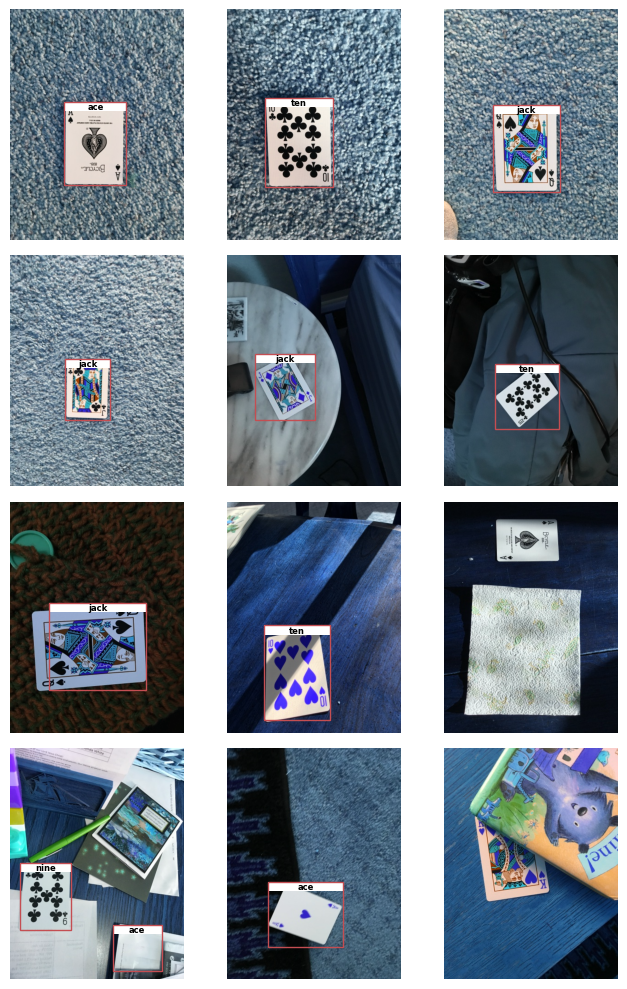

In [ ]:
fig, axes = plt.subplots(4, 3, figsize=(7, 10), dpi=100)

for i, ax in enumerate(axes.reshape(-1)):

    ax.axis(False)
    ax.imshow(results[i].orig_img)
    for cls, (x, y, _, _), (_, _, w, h) in zip(results[i].boxes.cls,
                                               results[i].boxes.xyxy,
                                               results[i].boxes.xywh):

        description_rect = Rectangle((x.item(), y.item()),
                                     w.item(),
                                     20,
                                     edgecolor='none',
                                     facecolor='w')
        ax.add_patch(description_rect)

        img_rect = Rectangle((x.item(), y.item()),
                             w.item(),
                             h.item(),
                             linewidth=1,
                             edgecolor='r',
                             facecolor='none')
        ax.add_patch(img_rect)

        cls = results[i].names[cls.item()]
        ax.annotate(cls,
                    (x.item() + w.item() / 2, y.item() + 20),
                    color='black',
                    weight='bold',
                    fontsize=6,
                    ha='center',
                    va='bottom')

fig.tight_layout()
plt.show()